In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct
from scipy.optimize import minimize

from data.record_webcam import WebcamImage
from data.compressed_sampling import Compression

%reload_ext autoreload
%autoreload 2

In [101]:
webcam = WebcamImage()
webcam.record_image()
webcam.get_grayscale()

resized = webcam.downsample(webcam.grayscale, scale = 0.1)

n_samples = np.round(0.2 * resized.shape[0] * resized[1])[0].astype(int)
compression = Compression(resized.flatten(), num_samples = n_samples)
compression.get_compressed_sample()


(720, 1280)
(128, 72)


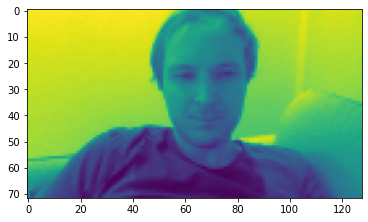

In [92]:
plt.imshow(resized)
plt.show()

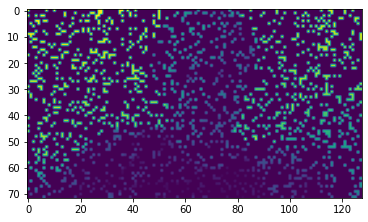

In [97]:
X = resized.flatten()
n = X.shape[0]
permutation = compression.sample_idx
compressed_signal = compression.compressed_signal

sample_img = np.zeros(X.shape)
sample_img[permutation] = X[permutation]

plt.imshow(sample_img.reshape(resized.shape))
plt.show()


In [98]:
def cosamp(sampling_matrix, sample_vector, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - sampling_matrix, sampling matrix Phi [n_samples x n_signal]
        - sample_vector, noisy sample vector
        - s, sparsity
    """
    n_samples, n_signal = sampling_matrix.shape
    best_signal_approx = np.zeros(sampling_matrix.shape[1])
    reconstr_error = sample_vector.copy()
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        transformed_signal = np.dot(np.transpose(sampling_matrix), reconstr_error) # reconstruct signal in cosine transformed coordinates 
        omega = np.argsort(transformed_signal)[-(2*s):] # get index of largest/most important components
        omega = np.union1d(omega, best_signal_approx.nonzero()[0]) # use set instead?
        sampling_matrixT = sampling_matrix[:, omega]
        signal_approx = np.zeros(n_signal)  # initiate sparse approx
        # Solve Least Square
        signal_approx[omega], _, _, _ = np.linalg.lstsq(sampling_matrixT, sample_vector) #(solve x: sample_vector = sampling_matrixT @ x)
        
        # Get new estimate
        signal_approx[np.argsort(signal_approx)[:-s]] = 0 # remove smallest entries
        best_signal_approx = signal_approx.copy()
        
        # Halt criterion
        reconstr_error_prev = reconstr_error.copy()
        reconstr_error = sample_vector - np.dot(sampling_matrix, best_signal_approx)

        halt = (np.linalg.norm(reconstr_error - reconstr_error_prev) < epsilon) or \
            np.linalg.norm(reconstr_error) < epsilon or \
            it > max_iter
        
    return best_signal_approx

In [99]:
Psi = dct(np.identity(n))
Theta = Psi[permutation, :]

s = cosamp(Theta, compressed_signal, 1000, epsilon = 1.e-10, max_iter = 10)
x_reconstructed = idct(s)
xt_reconstructed = np.fft.fft(x_reconstructed, n)
PSD_reconstructed = xt_reconstructed * np.conj(xt_reconstructed) / n

/Users/Jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(72, 128)


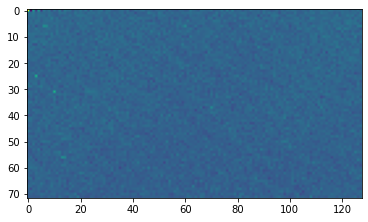

In [100]:
test = x_reconstructed.reshape(resized.shape)
print(test.shape)
plt.imshow(test.real)